OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

# PART 2 : Exploration of the dataset and Feature Engineering

### Introduction

#### Idea :

- The variable that we want to predict is : "TotalGHGEmissions"

1) Data visualization of "TotalGHGEmissions" and categorical features (like "BuildingType" for instance)
    Feature Engineering : delete features that do not help for the prediction.
2) Study distribution of quantitative features (energy variables etc)
    Feature Engineering :
    - delete features that won't be useful for the prediction of "TotalGHGEmissions"
    - apply transformations (log ? normalization ? etc skewness ??)
3) Correlation Matrix :
    Feature Engineering : delete features that are correlated (repeeated features like kWh and kBtu).

#### **Conclusion** of the exploration and feature engineering :

In [116]:
print("Source Energy Accounts for Total Energy Use")
features_to_predict = [
"SiteEnergyUse(kBtu)",
"SteamUse(kBtu)",
"Electricity(kBtu)",
"NaturalGas(kBtu)",
"TotalGHGEmissions"]

 # pour prédire les 4 premieres : avec le meme groupe de var (utilisation des carstetiques des bat)

print("Features to predict : ", features_to_predict)

Source Energy Accounts for Total Energy Use
Features to predict :  ['SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']


### Starting exploration

#### Importing libraries

In [117]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


#### Loading dataset

In [118]:
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode", "CouncilDistrictCode", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]

category_types = {column: 'category' for column in columns_to_categorize}
print("This dictionary will be used when reading the csv file to assign a type to categorical features :", category_types)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'BuildingType': 'category', 'PrimaryPropertyType': 'category', 'Neighborhood': 'category', 'ZipCode': 'category', 'CouncilDistrictCode': 'category', 'LargestPropertyUseType': 'category', 'SecondLargestPropertyUseType': 'category', 'ThirdLargestPropertyUseType': 'category'}


In [119]:
path = "./dataset/cleaned/"
filename = "2016_Building_Energy_Cleaned.csv"

dataset_path = "{}{}".format(path, filename)
# we assign the categorical features with a categotical type
dataset = pd.read_csv(dataset_path, dtype=category_types)

In [120]:
dataset.shape

(3131, 32)

In [121]:
dataset[:10]

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,25006,Multifamily LR (1-4),Low-Rise Multifamily,98112.0,3,central,1978,1,3,20739,0,20739,Multifamily Housing,17628,None,0,None,0,19,46,49,145,155,816300,869296,0,239244,816301,0,0,6,0
1,25025,NonResidential,Warehouse,98144.0,3,greater duwamish,1928,1,2,25955,0,25955,Non-Refrigerated Warehouse,14150,Other - Services,8745,Office,3060,-1,47,47,147,147,1218112,1218112,0,357008,1218112,0,0,8,0
2,25028,Multifamily LR (1-4),Low-Rise Multifamily,98144.0,2,greater duwamish,1925,1,3,25120,0,25120,Multifamily Housing,25120,None,0,None,0,98,23,24,50,53,586359,615255,0,89110,304043,2823,282316,17,1
3,25046,Multifamily HR (10+),High-Rise Multifamily,98144.0,2,greater duwamish,1971,1,15,73898,0,73898,Multifamily Housing,79912,None,0,None,0,75,40,43,99,106,3221754,3419862,0,631404,2154352,10674,1067402,72,1
4,25047,Multifamily LR (1-4),Low-Rise Multifamily,98108.0,2,greater duwamish,2001,1,3,36383,7030,29353,Multifamily Housing,25153,Office,4200,Parking,0,-1,33,35,81,84,960988,1019654,0,192884,658121,3029,302867,21,1
5,25002,NonResidential,Self-Storage Facility,98115.0,4,northeast,1996,1,4,38959,0,38959,Self-Storage Facility,38959,None,0,None,0,-1,23,25,53,54,905750,963968,0,154136,525913,3798,379837,24,1
6,25053,Multifamily LR (1-4),Low-Rise Multifamily,98115.0,4,northeast,1972,1,2,136752,0,136752,Multifamily Housing,113227,None,0,None,0,54,31,32,83,89,3466465,3631241,0,803640,2742019,7244,724446,58,0
7,25054,Multifamily LR (1-4),Low-Rise Multifamily,98115.0,4,northeast,1977,1,3,120701,0,120701,Multifamily Housing,98357,Parking,15448,None,0,69,30,32,93,100,2924362,3121704,0,857081,2924362,0,0,20,0
8,25055,Multifamily LR (1-4),Low-Rise Multifamily,98103.0,6,northwest,2006,1,4,54238,0,54238,Multifamily Housing,42377,None,0,None,0,32,32,34,102,106,1375979,1430023,0,403018,1375096,9,883,10,0
9,25001,NonResidential,Self-Storage Facility,98115.0,4,northeast,1947,1,3,22522,0,22522,Self-Storage Facility,22522,None,0,None,0,-1,25,28,39,42,561474,630413,0,40038,136609,4249,424865,24,1


In [122]:
dataset.dtypes

OSEBuildingID                         int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                       category
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEUI(kBtu/sf)                    float64
SiteEUIWN(kBtu/sf)                  float64
SourceEUI(kBtu/sf)                  float64
SourceEUIWN(kBtu/sf)            

In [123]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', None)

dataset.describe()

,OSEBuildingID,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131,3131
mean,21386,1969,1,5,89455,8375,81081,72981,13773,2020,50,55,58,136,140,4555983,4689270,140697,962106,3282707,11326,1132574,94,1
std,12023,33,1,6,140310,33187,121253,110482,36303,10786,38,56,57,139,139,9444934,9512455,1271303,2375385,8104814,24784,2478420,193,2
min,1,1900,1,0,11285,0,3636,5656,0,0,-1,2,0,7,0,113130,0,0,0,0,0,0,1,0
25%,20084,1948,1,2,28188,0,27502,24952,0,0,1,28,30,76,80,941051,990701,0,188772,644090,0,0,10,0
50%,23170,1975,1,4,43606,0,42401,38850,0,0,61,39,41,98,103,1791716,1895076,0,346147,1181054,3262,326159,34,1
75%,26003,1997,1,5,90000,0,83222,74836,11154,0,85,61,65,146,151,4206975,4383152,0,835012,2849061,11820,1182028,93,1
max,50226,2015,27,99,1952220,512608,1632820,1680937,438756,303910,100,834,834,2620,2620,274682208,274725984,31030194,80460872,274532495,346853,34685331,2574,26


### 1) Plot kWh / kBtu and therms / kBtu

Natural Gas


<AxesSubplot:xlabel='NaturalGas(therms)', ylabel='NaturalGas(kBtu)'>

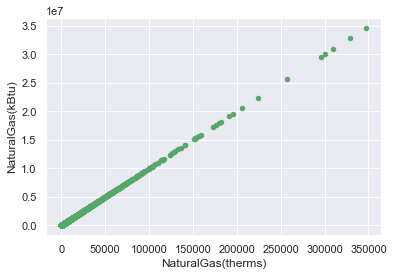

In [124]:
print("Natural Gas")
dataset.plot.scatter("NaturalGas(therms)", "NaturalGas(kBtu)", c="g")

Electricity


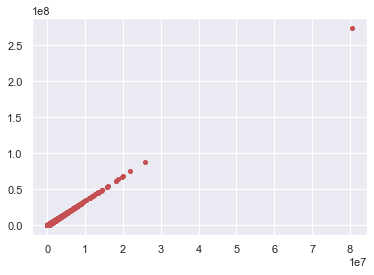

In [125]:
# Easy Linear Regression : x = kWh y = kBtu
print("Electricity")
plt.plot(dataset["Electricity(kWh)"], dataset["Electricity(kBtu)"], "ro", markersize=4)
plt.show()

In [126]:
print("After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.")
dataset_v1 = dataset.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

After checking that the Electricity in kWh = 3.412 Electricity in kBtu and that NaturalGas(therms) = 100 NaturalGas(kBtu) ; we drop the kWh and therms.


We tried to implement linear regression to verify that :
- the Electricity in kWh x 3.412 = Electricity in kBtu,
- the NaturalGas in Therms x 99.98 = NaturalGas in kBtu.


#### Manual Linear Regression

In [127]:
# Linear Regression "manually" / we transform the dataset into matrices to compute theta
X = np.matrix([np.ones(dataset.shape[0]), dataset["Electricity(kWh)"]]).T
Y = np.matrix(dataset["Electricity(kBtu)"]).T

In [128]:
np.set_printoptions(suppress=True) # remove scientific notation
X[:10]

matrix([[     1.     , 239244.     ],
        [     1.     , 357008.1875 ],
        [     1.     ,  89109.89844],
        [     1.     , 631404.3125 ],
        [     1.     , 192884.0938 ],
        [     1.     , 154136.4063 ],
        [     1.     , 803639.6875 ],
        [     1.     , 857081.375  ],
        [     1.     , 403017.5    ],
        [     1.     ,  40037.80078]])

In [129]:
# Computing the exact value of the parameter theta
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

# displaying theta with a = slope ; and b = y-intercept
print(theta)

# we test Y = aX + b for X = 10
print(theta.item(0) + theta.item(1) * 10)

[[0.00971308]
 [3.412     ]]
34.12971304320073


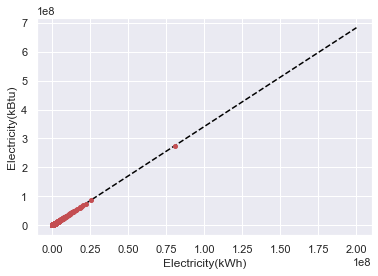

In [130]:
plt.xlabel("Electricity(kWh)")
plt.ylabel("Electricity(kBtu)")

x_min = 0
x_max = 200000000
y_min = theta.item(0)
y_max = theta.item(0) + x_max * theta.item(1)

plt.plot([x_min, x_max], [y_min, y_max], linestyle="--", c="#000000")
plt.plot(dataset["Electricity(kWh)"], dataset["Electricity(kBtu)"], "ro", markersize=4)

plt.show()

#### Automatic Linear Regression

In [131]:
# 0) Getting data and Sampling
from sklearn.linear_model import LinearRegression

X = dataset["Electricity(kWh)"]
y = dataset["Electricity(kBtu)"] # target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# reshape to get 2D array instead of 1D array.
# values to get a numpy array instead of a pandas Series
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [132]:
X_train

array([[494647.6875 ],
       [362029.     ],
       [ 82651.20313],
       ...,
       [495302.4063 ],
       [189171.0938 ],
       [161899.5    ]])

In [133]:
# 1) Training Linear Regression and Evaluating
reg = LinearRegression().fit(X_train, y_train)
prediction_score = reg.score(X_test, y_test)
#print("Accuracy is : %.2f" % (100 * prediction_score))
print('Accuracy is : {:.0%}'.format(prediction_score))

# 2) Trying to predict a value
reg.predict([[10]]) # if X = 10 kWh then Y = 34.12 kBtu ;)

Accuracy is : 100%


array([[34.12840723]])

Electricity prediction


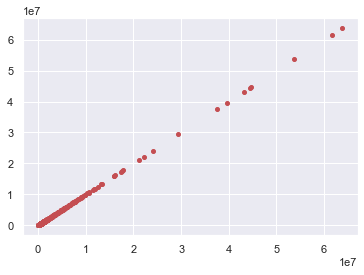

In [134]:
print("Electricity prediction")
plt.plot(reg.predict(X_test), y_test, "ro", markersize=4)
plt.show()

#### Conclusion :
This Linear Rregression was for training purposes.
We remove the redundant features like Electricity in kWh and NaturalGas in Therms.

Thanks to the correlation matrix below, we will be able to choose the features that will help our prediction model.

for column in dataset_v1.select_dtypes(['int32', 'float64']).columns:
    plt.figure(figsize=(12,6))
    plt.title('Distribution de ' + column)
    sns.histplot(data[column], bins=20)

### 2) Correlation Matrix

#### 2.1) Correlation between energy variables

In [135]:
all_energy_features = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)",
                       "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", "SteamUse(kBtu)", "Electricity(kBtu)",
                       "NaturalGas(kBtu)", "TotalGHGEmissions", "GHGEmissionsIntensity"]

In [136]:
# exploration : matrice corrélation et corrélation entre categorielles et quantitatives (GHGE corrélé avec var consom E (elctricity, steam etc)
# predict : consomation bat puis avec ca predire l'emission CO2
# 1) prediction consommation sur l'énergie puis predire CO2 (le + long le +complexe)
# categories batiments mal ecrites / numeriques incohérentes

We display here the correlation matrix without options to justify the display below.


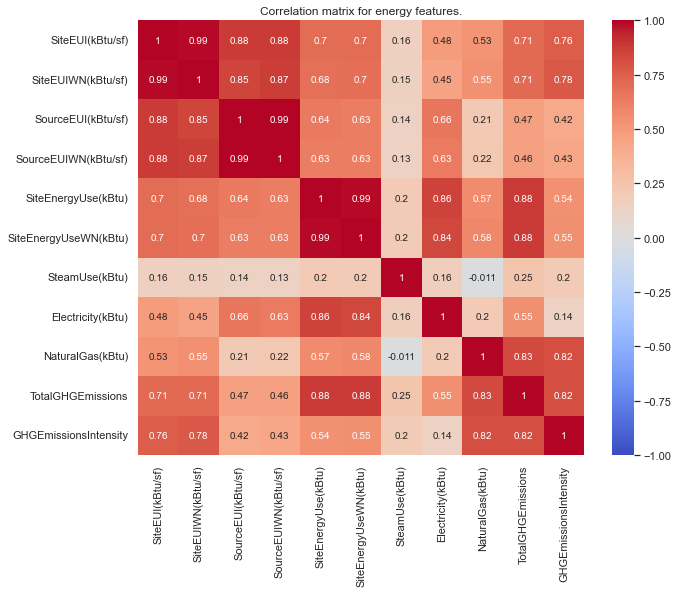

In [137]:
# we create a dataframe with all the energy features.
df_to_corr = dataset_v1[all_energy_features]

# we assign the type float to all the values of the matrix
df_to_corr = df_to_corr.astype(float)
corr_df = df_to_corr.corr(method='spearman')

print("We display here the correlation matrix without options to justify the display below.")
plt.figure(figsize=(10, 8))
plt.title('Correlation matrix for energy features.')
sns.heatmap(corr_df, annot=True, vmin=-1, cmap='coolwarm')
plt.show()

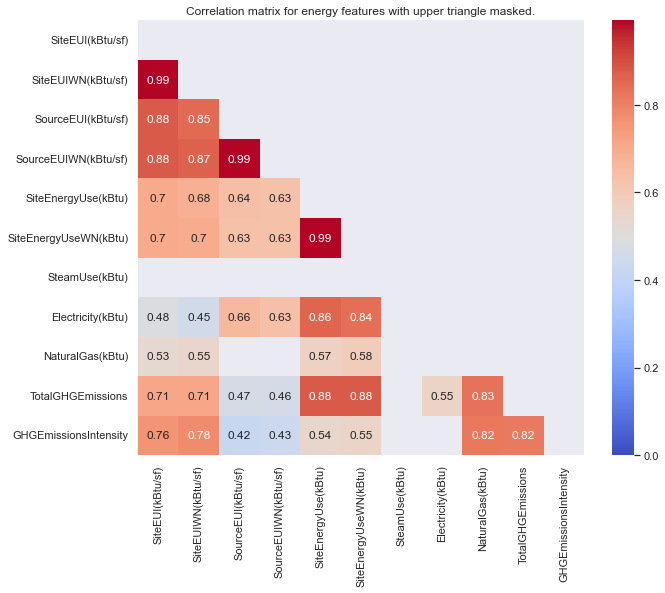

In [138]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=1)
plt.title('Correlation matrix for energy features with upper triangle masked.')

# to hide the upper triangle of the matrix
trimask = np.zeros_like(corr_df)
trimask[np.triu_indices_from(trimask)] = True
sns.heatmap(corr_df, annot=True, mask= trimask | (np.abs(corr_df) <= 0.4), vmin=0, cmap='coolwarm') # we don't have negative correlations here

plt.show()

**Interpretation** :

- We can see a strong correlation between the variables.


**Conclusion** :
- We will drop the variables Weather Normalized,
- We drop the variable GHGEmissionsIntensity.

#### 2.2) Correlation matrix with all features

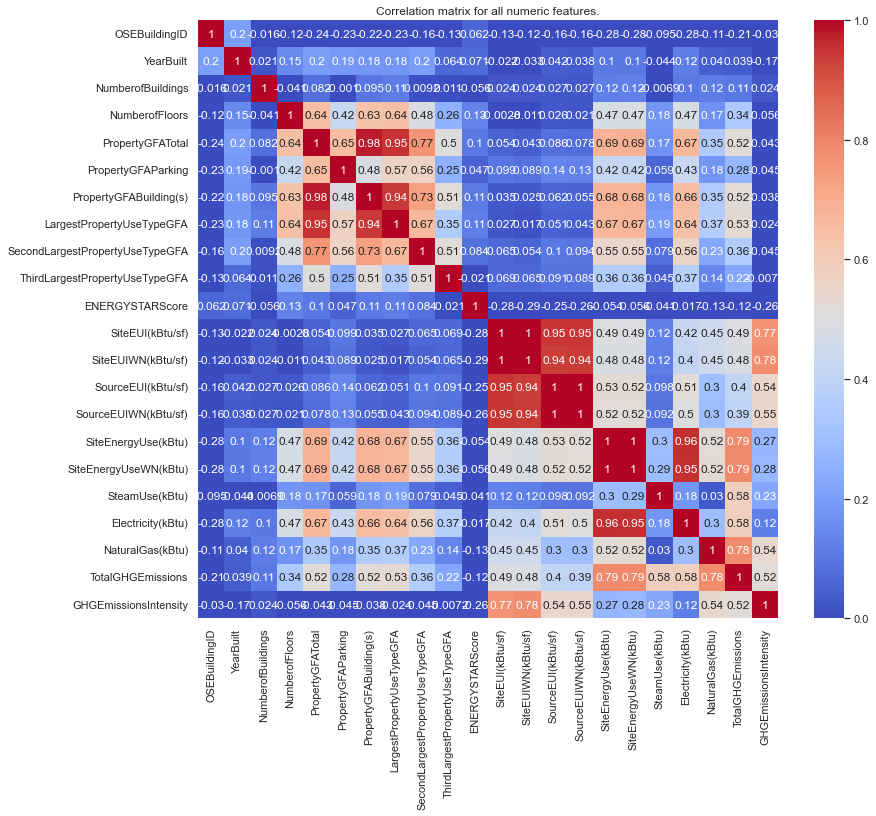

In [139]:
numeric_columns = dataset_v1.select_dtypes(include = ['int64','float64']).columns
corr = dataset_v1[numeric_columns].corr()

plt.figure(figsize=(13, 11))
sns.set(font_scale=1)
plt.title('Correlation matrix for all numeric features.')

# to hide the upper triangle of the matrix
trimask = np.zeros_like(corr)
trimask[np.triu_indices_from(trimask)] = True
sns.heatmap(corr, annot=True, vmin=0, cmap='coolwarm') # we don't have negative correlations here

plt.show()

dataset_v1.columns

In [140]:
print("ASK MENTOR INTERPRETATION CORR MATRIX")
# carac bat interess pour predirection / redtirer quand trop correlees entre elles

ASK MENTOR INTERPRETATION CORR MATRIX


**Interpretation** :

- We can see a strong correlation between the variables.


**Conclusion** :
- We will drop the variables Weather Normalized,
- We drop the variable GHGEmissionsIntensity.

In [141]:
correlated_features = ["SiteEUI(kBtu/sf)", 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', "GHGEmissionsIntensity"]

In [142]:
dataset_v2 =dataset_v1.drop(columns=correlated_features, inplace=False)

### 3) Distribution of quantitative variables

In [143]:
dataset_v2.dtypes

OSEBuildingID                         int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                       category
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEnergyUse(kBtu)                 float64
SteamUse(kBtu)                      float64
Electricity(kBtu)                   float64
NaturalGas(kBtu)                

After removing outliers, we display boxplot per energy feature and per Primary Property Type.
We suppose that a K-12 School has different energy needed compared to a hospital, so the boxplot must represent that difference.


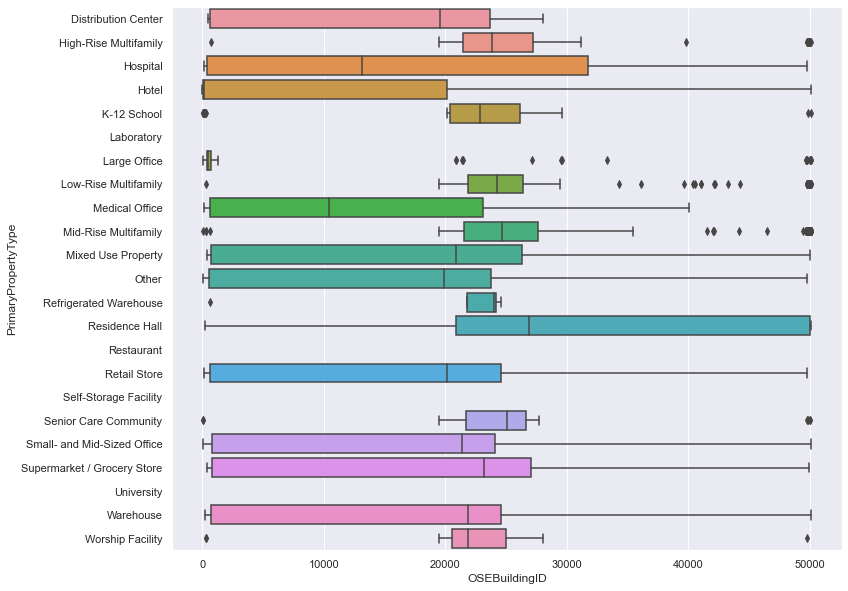

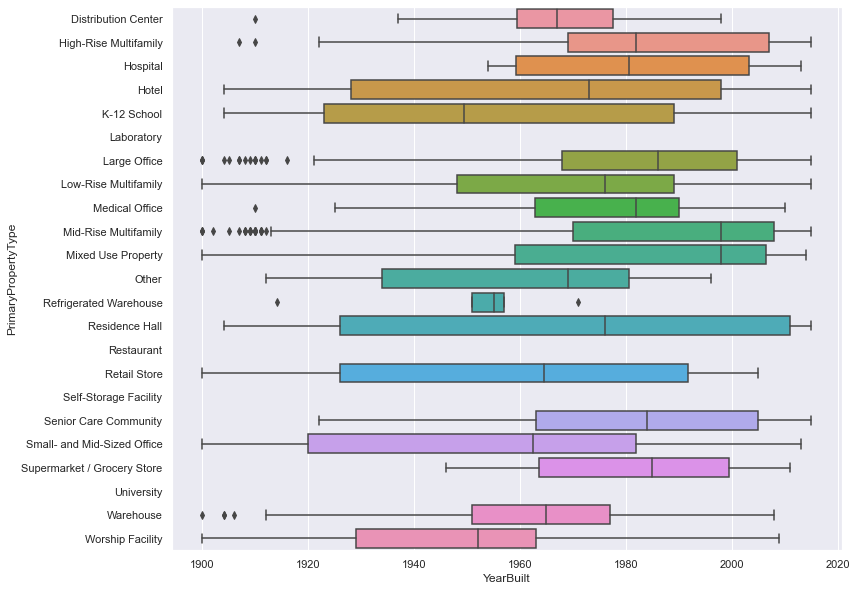

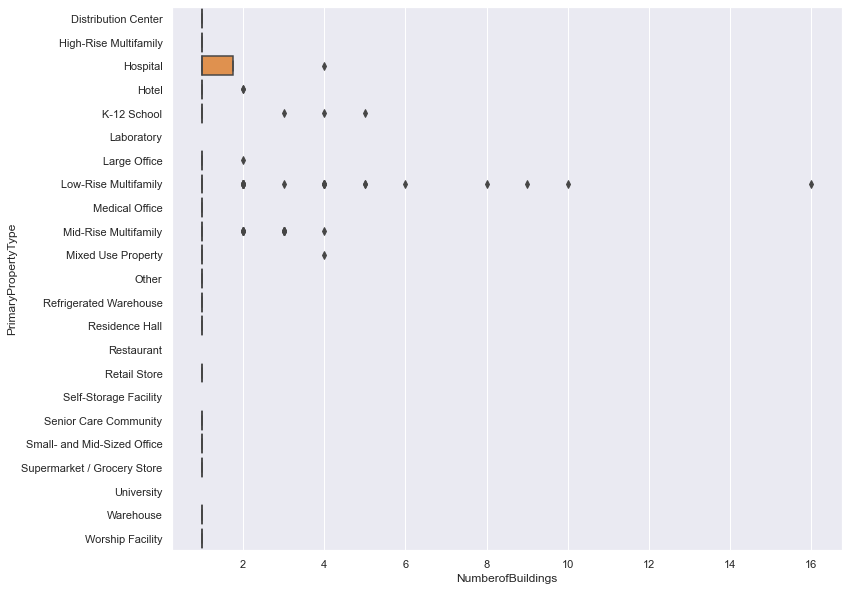

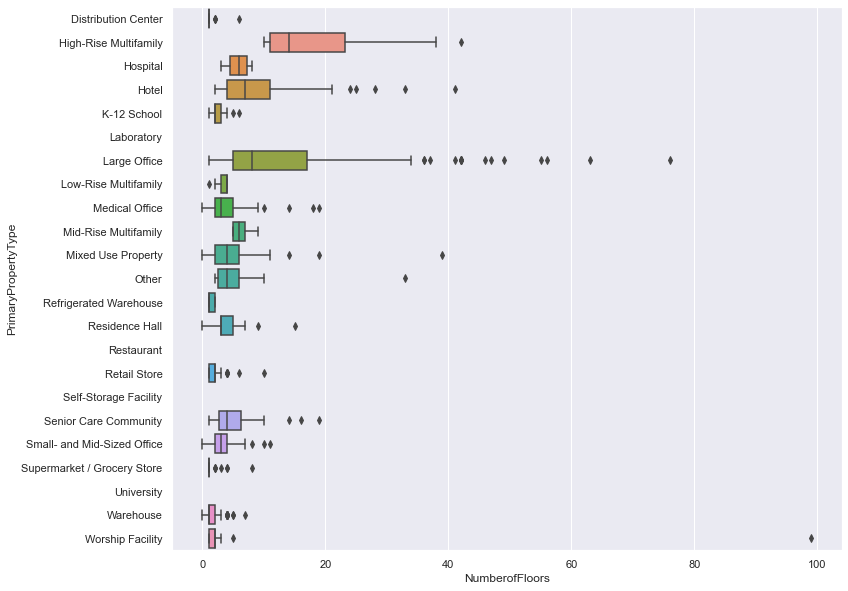

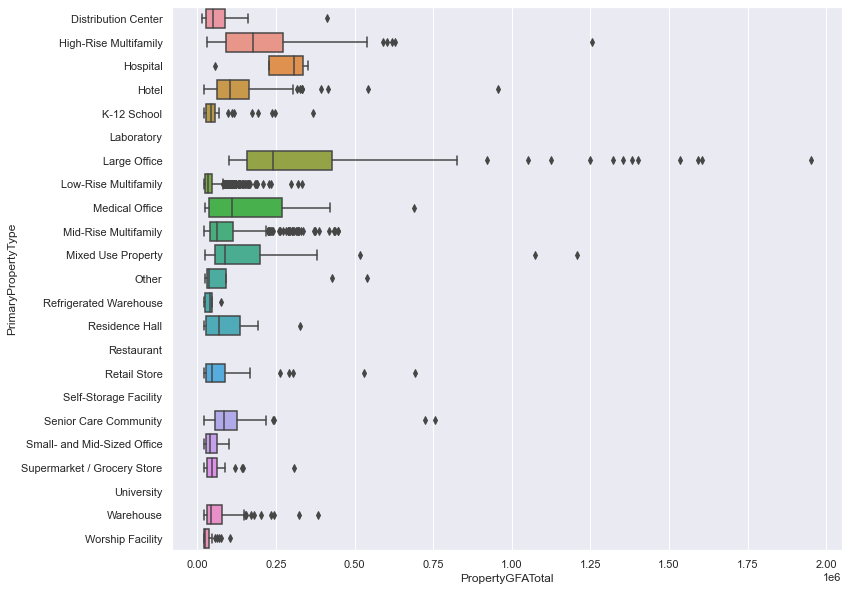

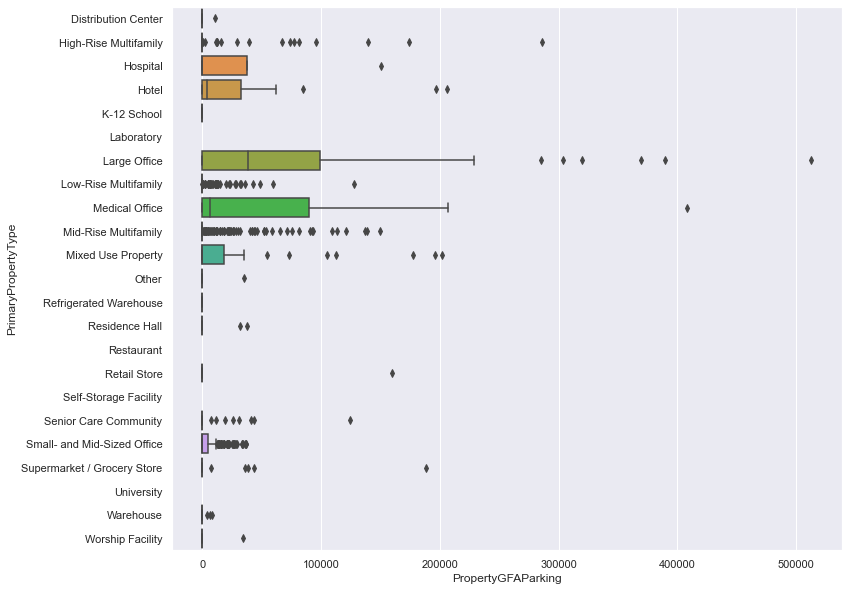

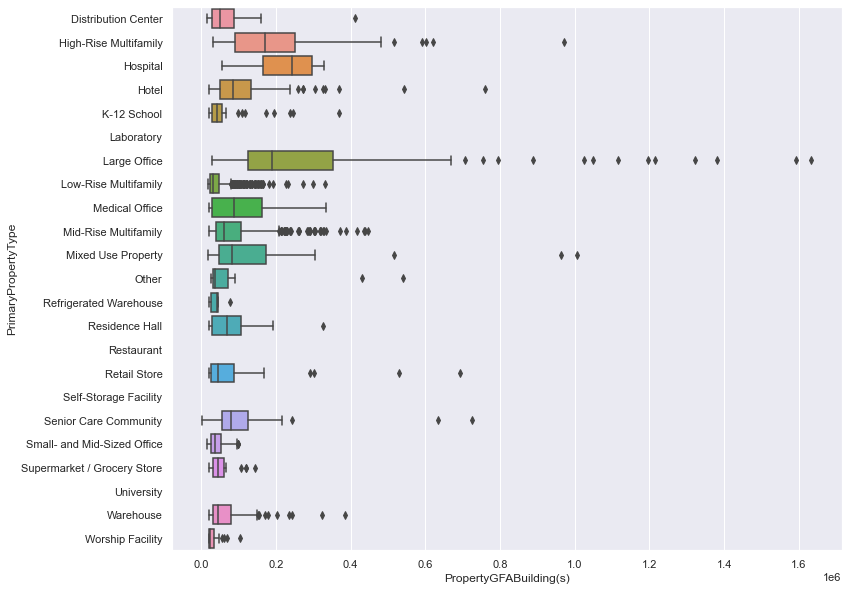

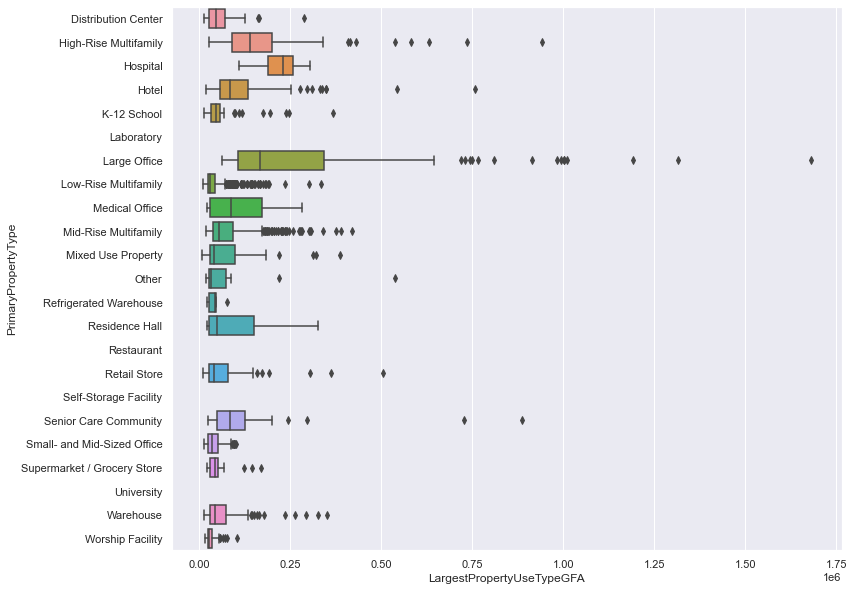

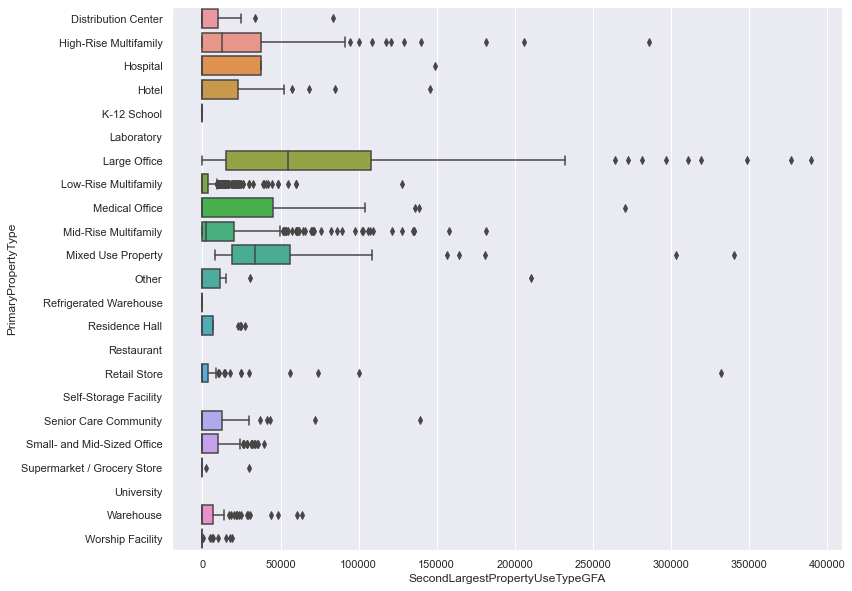

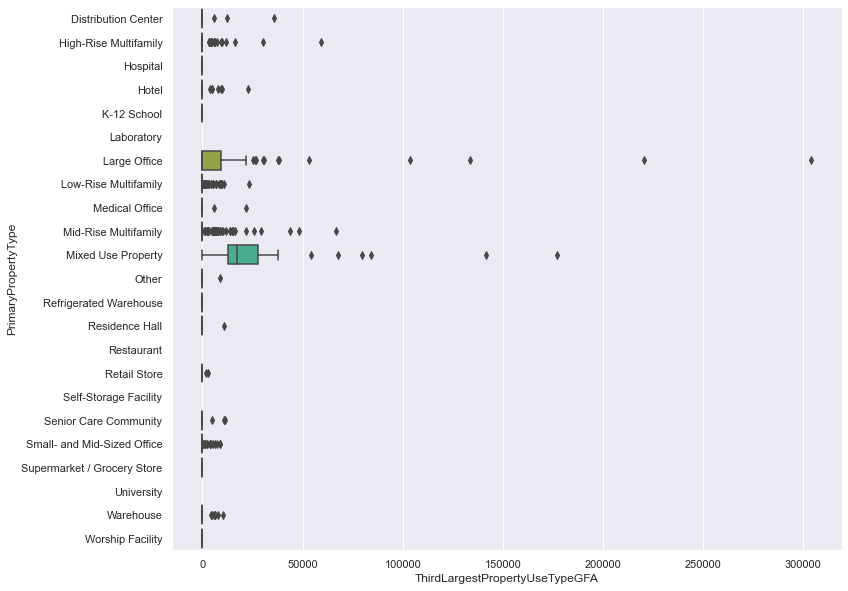

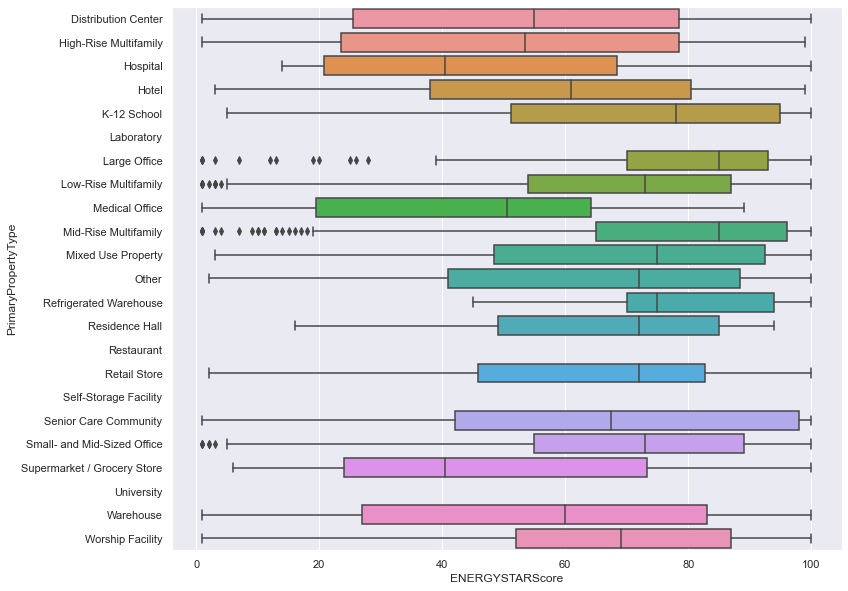

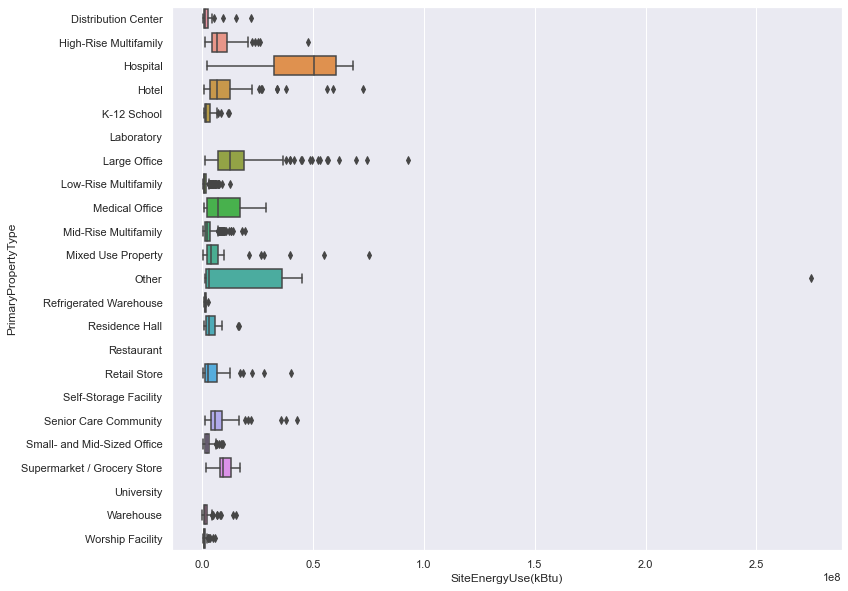

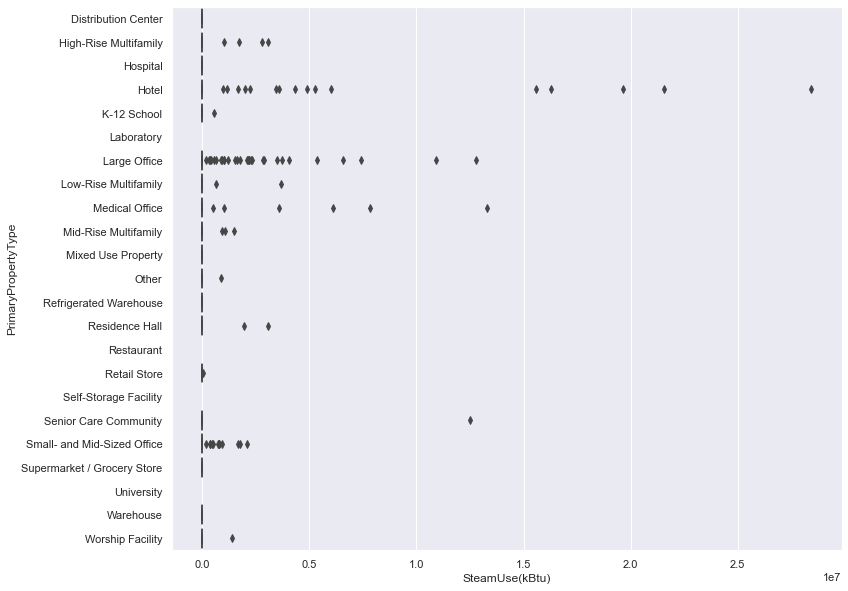

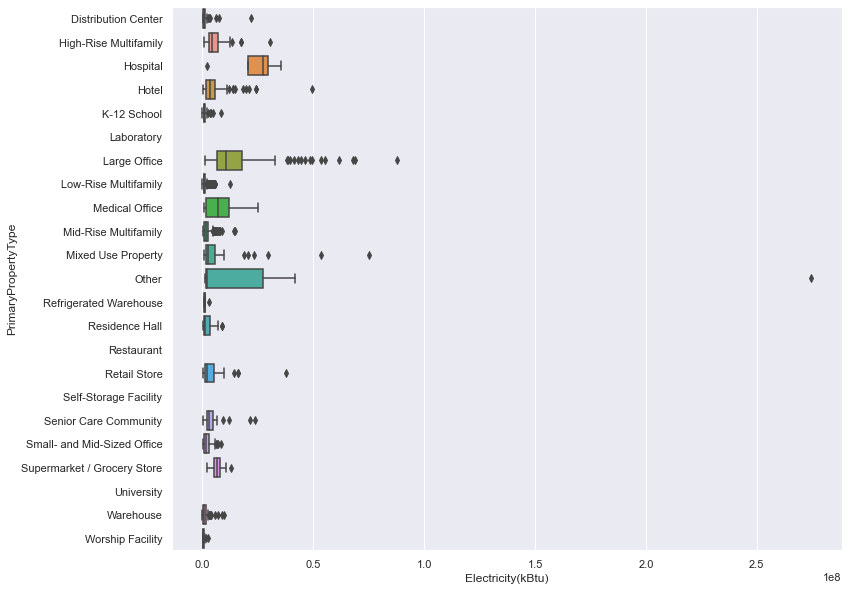

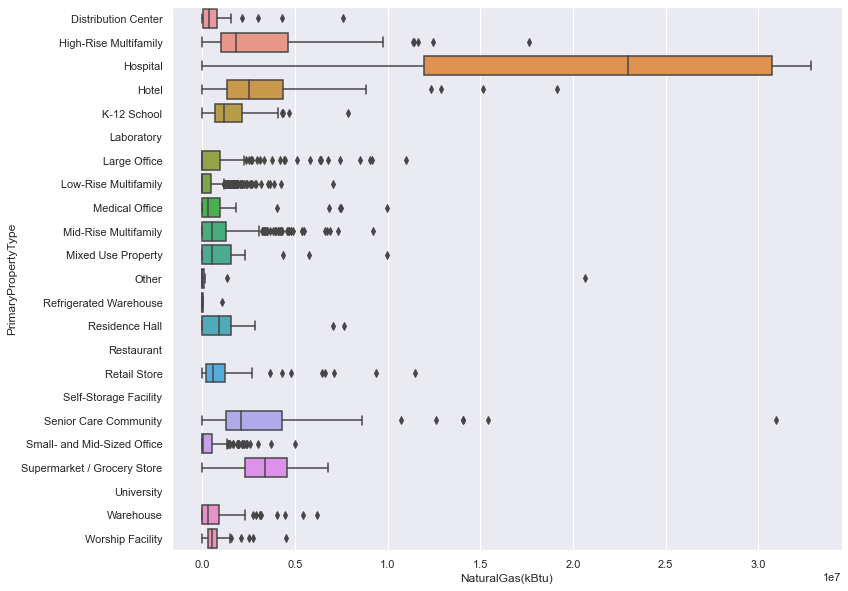

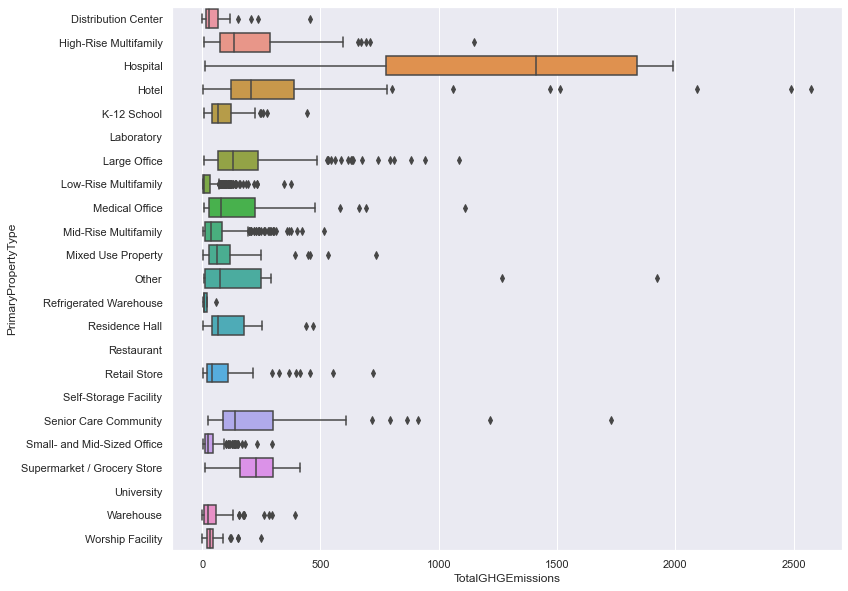

In [144]:
def display_boxplot_per_feature(data_frame, x_all_features, y_category):
    """

    :param data_frame:
    :param x_all_features: (list) a list of features to plot (column names, numeric variables)
    :param y_category: (string) category to make different plots
    :return:
    """
    # to make the graphs bigger
    sns.set(rc={'figure.figsize':(12,10)})
    for i, feature in enumerate(x_all_features):
        plt.figure(i)
        sns.boxplot(data=data_frame, x=feature, y=y_category)


print("After removing outliers, we display boxplot per energy feature and per Primary Property Type.")
print("We suppose that a K-12 School has different energy needed compared to a hospital, so the boxplot must represent that difference.")

data_boxplot = dataset_v2.copy()
data_boxplot.loc[data_boxplot["ENERGYSTARScore"] == -1] = np.nan

display_boxplot_per_feature(data_boxplot, data_boxplot.select_dtypes(include = ['int32','float64']).columns.tolist(), "PrimaryPropertyType")

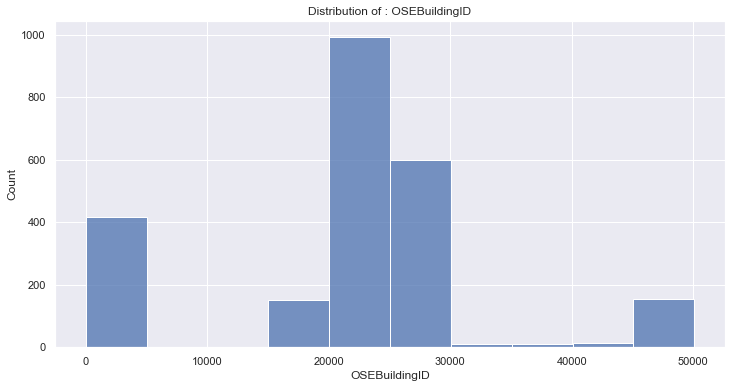

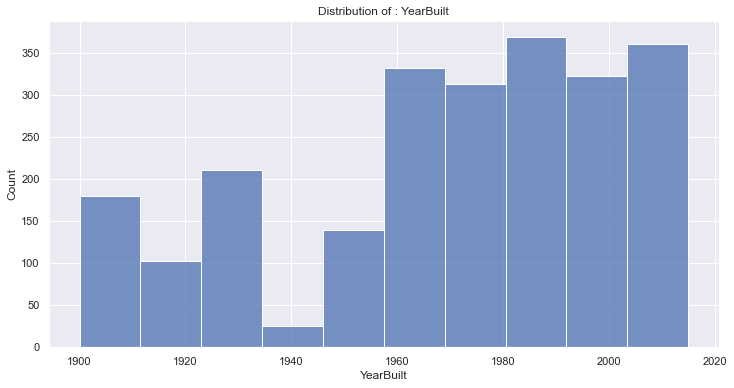

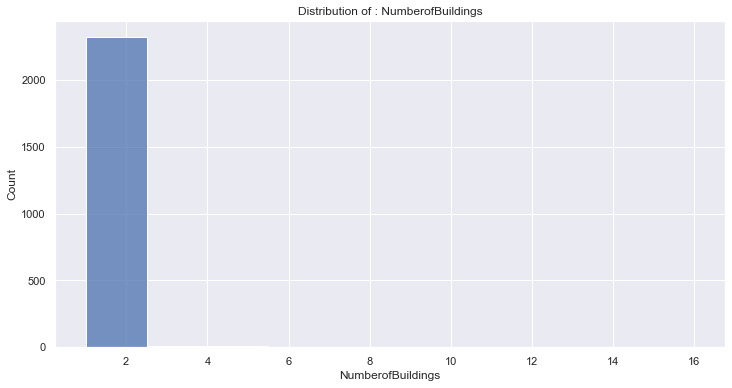

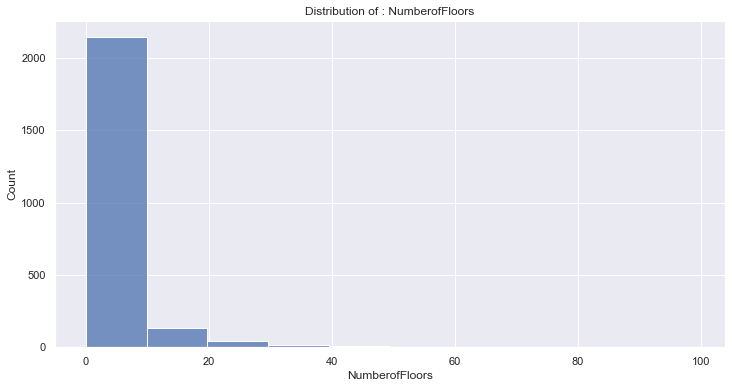

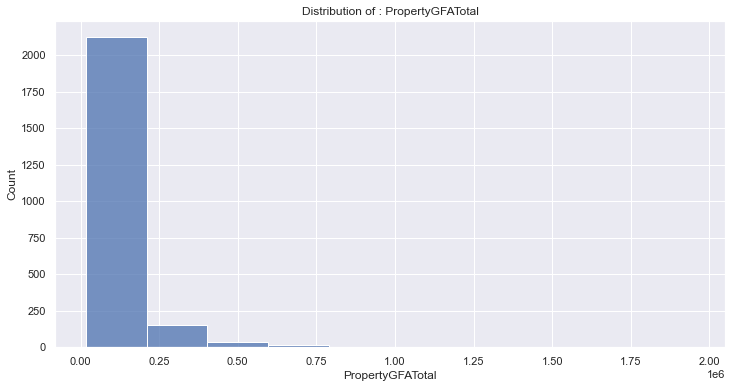

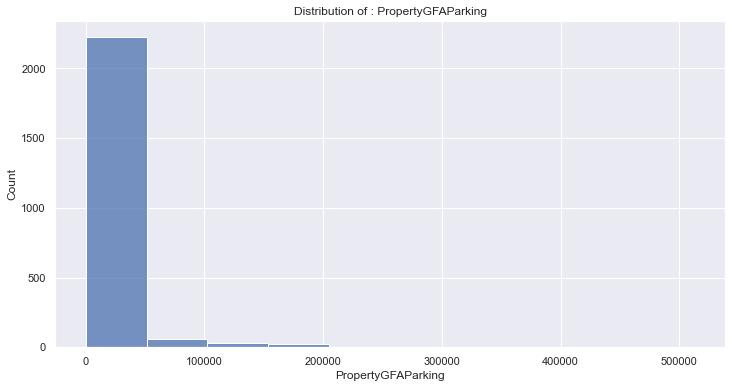

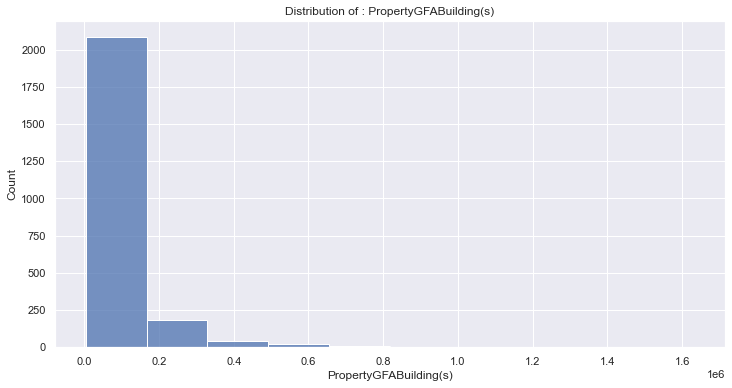

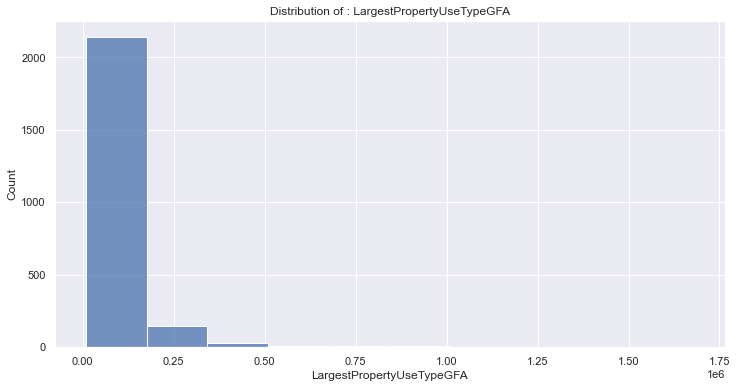

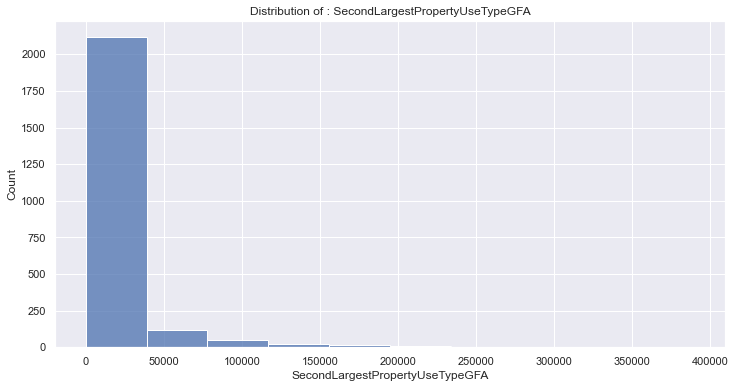

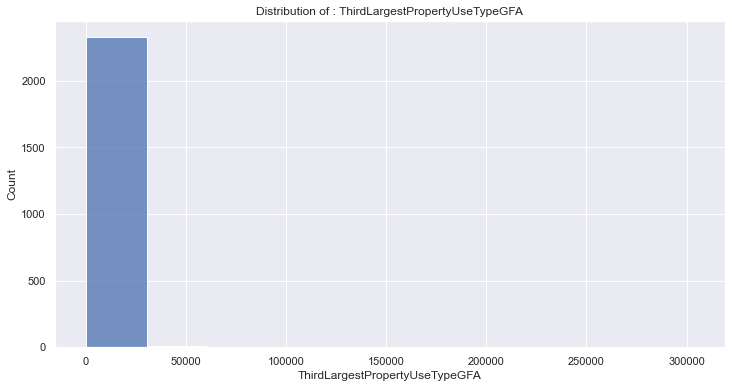

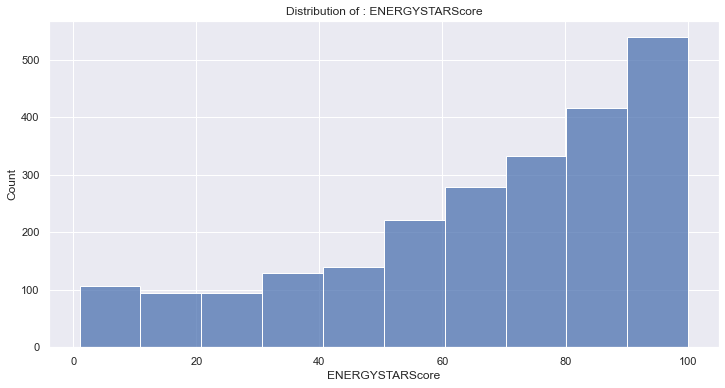

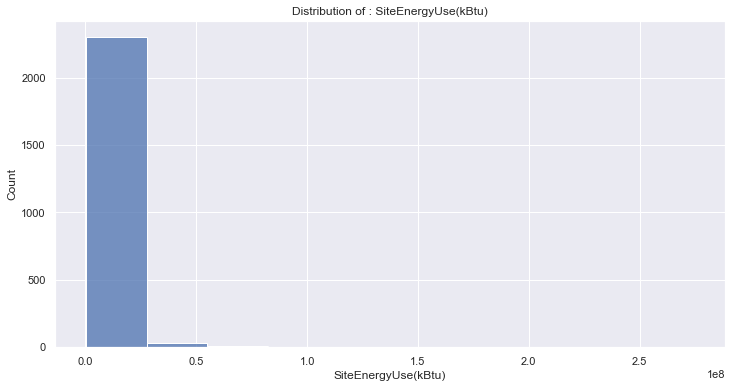

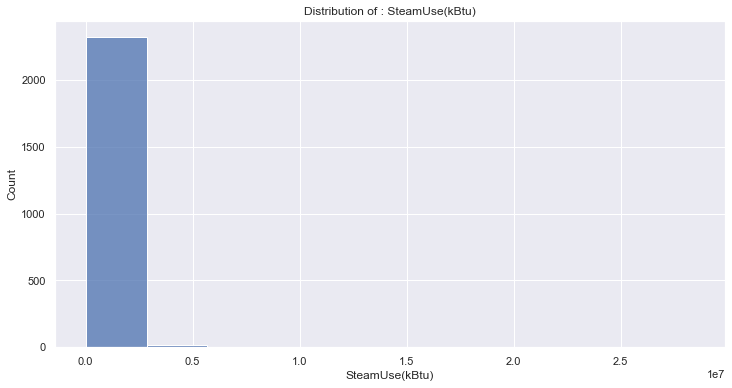

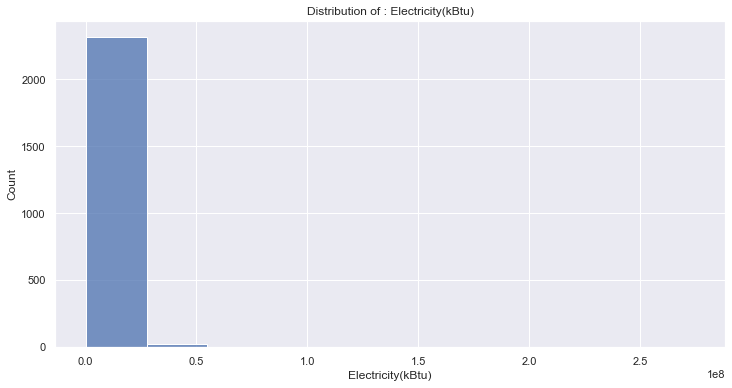

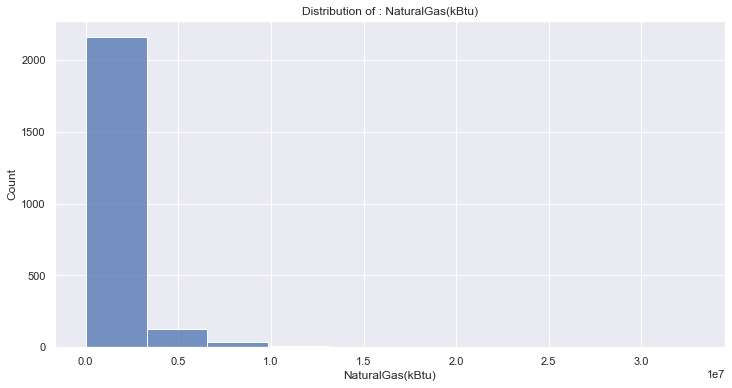

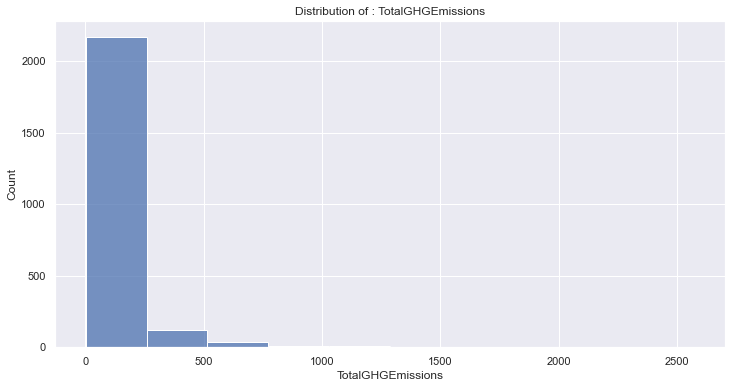

In [145]:
def display_distribution_per_feature(data_frame, all_features, nb_bins):
    """

    :return:
    """
    for column in all_features:
        plt.figure(figsize=(12,6))
        plt.title('Distribution of : ' + column)
        sns.histplot(data_frame[column], bins=nb_bins)

display_distribution_per_feature(data_boxplot, data_boxplot.select_dtypes(include='number').columns, 10)

In [146]:
dataset_v2.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

In [ ]:
features_for_prediction = ["YearBuilt", "CouncilDistrictCode", "Neighborhood", "NumberofBuildings", "NumberofFloors", "BuildingType", "PrimaryPropertyType", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]

from functions import densite
densite(dataset_v2[features_for_prediction])

### 4) Combining variables

In [148]:
dataset_v2.dtypes

OSEBuildingID                         int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                       category
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEnergyUse(kBtu)                 float64
SteamUse(kBtu)                      float64
Electricity(kBtu)                   float64
NaturalGas(kBtu)                

Pie chart showing the distribution of the buildings in our database per building type.


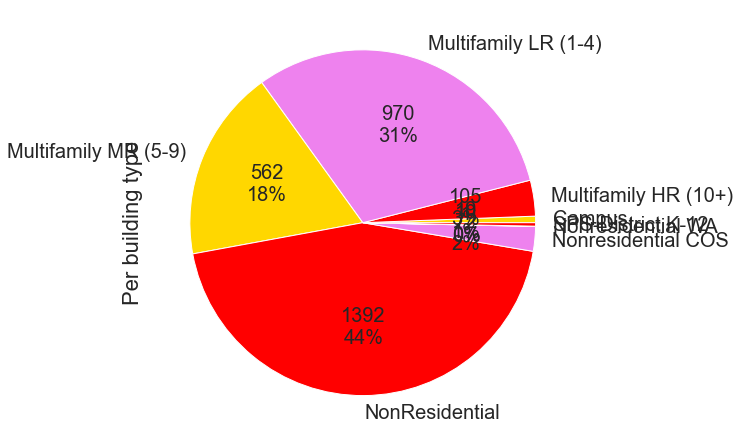

In [149]:
print("Pie chart showing the distribution of the buildings in our database per building type.")

# Pie chart
def label_function(val):
    return f'{val / 100 * len(dataset_v2):.0f}\n{val:.0f}%'

fig, ax = plt.subplots(figsize=(10, 10))

dataset_v2.groupby('BuildingType').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                              colors=['gold', 'red', 'violet'], ax=ax)

ax.set_ylabel('Per building type', size=22)
plt.tight_layout()
plt.show()

In [150]:
# nettoyer : filtrer en ligne / quelques graphiques pour la presentation et mieux visualier / pour justifier des filtres

### 5) Transformation : variables to predict

##### Log transformation for the features to predict

In [151]:
features_to_predict = [
    "SiteEnergyUse(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kBtu)",
    "NaturalGas(kBtu)",
    "TotalGHGEmissions"]

print(features_to_predict)

['SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']


In [152]:
dataset_v3 = dataset_v2.copy()

print('Transformation en log2 de la variable à prédire...')
for feature in features_to_predict:
    log_feature = "Log2-{}".format(feature)
    dataset_v3[log_feature] = np.log2(1 + dataset_v3[feature])

display(dataset_v3)

Transformation en log2 de la variable à prédire...


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Log2-SiteEnergyUse(kBtu),Log2-SteamUse(kBtu),Log2-Electricity(kBtu),Log2-NaturalGas(kBtu),Log2-TotalGHGEmissions
0,25006,Multifamily LR (1-4),Low-Rise Multifamily,98112.0,3,central,1978,1,3,20739,0,20739,Multifamily Housing,17628,None,0,None,0,19,816300,0,816301,0,6,20,0,20,0,3
1,25025,NonResidential,Warehouse,98144.0,3,greater duwamish,1928,1,2,25955,0,25955,Non-Refrigerated Warehouse,14150,Other - Services,8745,Office,3060,-1,1218112,0,1218112,0,8,20,0,20,0,3
2,25028,Multifamily LR (1-4),Low-Rise Multifamily,98144.0,2,greater duwamish,1925,1,3,25120,0,25120,Multifamily Housing,25120,None,0,None,0,98,586359,0,304043,282316,17,19,0,18,18,4
3,25046,Multifamily HR (10+),High-Rise Multifamily,98144.0,2,greater duwamish,1971,1,15,73898,0,73898,Multifamily Housing,79912,None,0,None,0,75,3221754,0,2154352,1067402,72,22,0,21,20,6
4,25047,Multifamily LR (1-4),Low-Rise Multifamily,98108.0,2,greater duwamish,2001,1,3,36383,7030,29353,Multifamily Housing,25153,Office,4200,Parking,0,-1,960988,0,658121,302867,21,20,0,19,18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,21122,NonResidential,Mixed Use Property,98103.0,6,lake union,2001,5,3,41827,9226,32601,Multifamily Housing,14273,Office,14128,Parking,9680,-1,4193371,0,2439095,1754275,110,22,0,21,21,7
3127,21124,Multifamily LR (1-4),Low-Rise Multifamily,98103.0,6,lake union,1907,1,4,36660,0,36660,Multifamily Housing,36660,None,0,None,0,98,930368,0,517619,412749,26,20,0,19,19,5
3128,21125,NonResidential,Small- and Mid-Sized Office,98103.0,6,lake union,2001,1,5,33740,6010,27730,Office,15908,Retail Store,8762,Parking,1500,79,1291405,0,1291405,0,9,20,0,20,0,3
3129,21129,NonResidential,Retail Store,98103.0,6,lake union,1911,1,2,20516,0,20516,Retail Store,10155,Hotel,8000,None,0,98,1021797,0,264984,756812,42,20,0,18,20,5


##### Saving cleaned dataset

In [153]:
# We reset the index
final_dataset = dataset_v3.reset_index(drop = True)

# Save
export_path = "./dataset/cleaned/"
export_filename = "2016_Building_Energy_Prediction.csv"
final_dataset.to_csv("{}{}".format(export_path, export_filename), index=False)